In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
# Import metrics from scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set random seed and device
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define data transformations for CIFAR100
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

# Load CIFAR100 dataset
cifar100_full = torchvision.datasets.CIFAR100(root='./datasets', train=True, download=True, transform=transform_train)
train_size = int(0.9 * len(cifar100_full))
val_size = len(cifar100_full) - train_size
cifar100_train, cifar100_val = random_split(cifar100_full, [train_size, val_size])

cifar100_test = torchvision.datasets.CIFAR100(root='./datasets', train=False, download=True, transform=transform_test)

batch_size = 128
train_loader = DataLoader(cifar100_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(cifar100_val, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar100_test, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# BasicBlock for ResNet-11 with dropout
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, dropout_p=0.3):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_p)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.dropout(out)
        out = self.relu(out)
        return out

# Definition of ResNet-11 with dropout
class ResNet11(nn.Module):
    def __init__(self, num_classes=10, dropout_p=0.3):
        super(ResNet11, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 1, stride=1, dropout_p=dropout_p)
        self.layer2 = self._make_layer(128, 1, stride=2, dropout_p=dropout_p)
        self.layer3 = self._make_layer(256, 1, stride=2, dropout_p=dropout_p)
        self.layer4 = self._make_layer(512, 1, stride=2, dropout_p=dropout_p)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * BasicBlock.expansion, num_classes)
        
    def _make_layer(self, out_channels, blocks, stride, dropout_p):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, dropout_p))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels, stride=1, dropout_p=dropout_p))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [4]:
# load model
model = ResNet11(num_classes=100).to(device)
print(model)

OriginalAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Dropout(p=0.3, inplace=False)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Dropout(p=0.3, inplace=False)
    (17): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return running_loss / len(dataloader.dataset), correct / total


print("Selected AlexNet parameter count:", count_parameters(model))

Selected AlexNet parameter count: 23640996


In [6]:
num_epochs = 30
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/30: Train Loss: 4.3881, Val Loss: 4.2035, Val Acc: 0.0444
Epoch 2/30: Train Loss: 4.0443, Val Loss: 4.1556, Val Acc: 0.0484
Epoch 3/30: Train Loss: 3.9148, Val Loss: 4.0289, Val Acc: 0.0728
Epoch 4/30: Train Loss: 3.8122, Val Loss: 3.9155, Val Acc: 0.0946
Epoch 5/30: Train Loss: 3.7450, Val Loss: 3.8892, Val Acc: 0.0956
Epoch 6/30: Train Loss: 3.6859, Val Loss: 3.7919, Val Acc: 0.1108
Epoch 7/30: Train Loss: 3.6395, Val Loss: 3.7806, Val Acc: 0.1188
Epoch 8/30: Train Loss: 3.6106, Val Loss: 3.7236, Val Acc: 0.1232
Epoch 9/30: Train Loss: 3.5849, Val Loss: 3.7258, Val Acc: 0.1278
Epoch 10/30: Train Loss: 3.5540, Val Loss: 3.6334, Val Acc: 0.1366
Epoch 11/30: Train Loss: 3.5172, Val Loss: 3.5908, Val Acc: 0.1494
Epoch 12/30: Train Loss: 3.5047, Val Loss: 3.6486, Val Acc: 0.1398
Epoch 13/30: Train Loss: 3.4855, Val Loss: 3.5892, Val Acc: 0.1538
Epoch 14/30: Train Loss: 3.4599, Val Loss: 3.5803, Val Acc: 0.1528
Epoch 15/30: Train Loss: 3.4483, Val Loss: 3.5567, Val Acc: 0.1602
Epoc

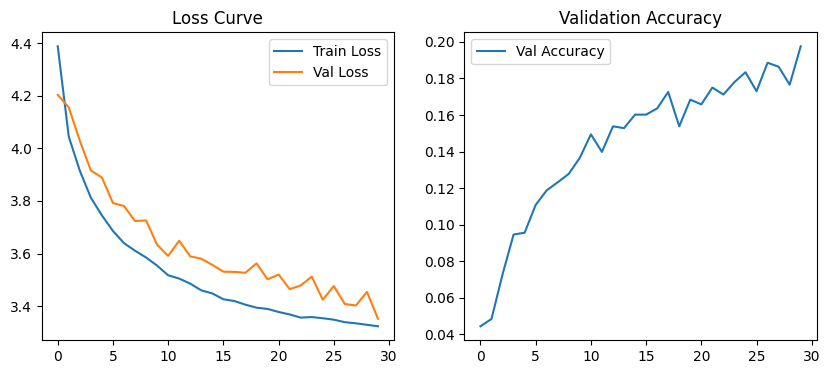

In [7]:
# Save training data and plot the curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Validation Accuracy")
plt.savefig("./images/p3_100_dropout_ResNet11_results.png")
plt.show()

In [8]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

In [9]:
# Compute predictions on the test set
test_preds, test_targets = compute_metrics(model, test_loader)

# Calculate precision, recall, and F1 score (weighted average)
precision = precision_score(test_targets, test_preds, average="weighted")
recall = recall_score(test_targets, test_preds, average="weighted")
f1 = f1_score(test_targets, test_preds, average="weighted")
conf_matrix = confusion_matrix(test_targets, test_preds)
class_report = classification_report(test_targets, test_preds, target_names=cifar100_test.classes)

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Test Precision: 0.2659145457530781
Test Recall: 0.2138
Test F1 Score: 0.20229754822525287

Confusion Matrix:
 [[49  2  2 ...  0  0  0]
 [ 0 28  0 ...  2  0  0]
 [ 0  0 14 ... 10  3  0]
 ...
 [ 0  0  0 ... 50  0  0]
 [ 0  0  4 ... 14  6  0]
 [ 2  0  0 ...  3  0  2]]

Classification Report:
                precision    recall  f1-score   support

        apple       0.73      0.49      0.59       100
aquarium_fish       0.21      0.28      0.24       100
         baby       0.27      0.14      0.18       100
         bear       0.12      0.12      0.12       100
       beaver       0.07      0.01      0.02       100
          bed       0.13      0.44      0.20       100
          bee       0.17      0.08      0.11       100
       beetle       0.09      0.09      0.09       100
      bicycle       0.10      0.31      0.15       100
       bottle       0.41      0.24      0.30       100
         bowl       0.00      0.00      0.00       100
          boy       0.00      0.00      0.00    

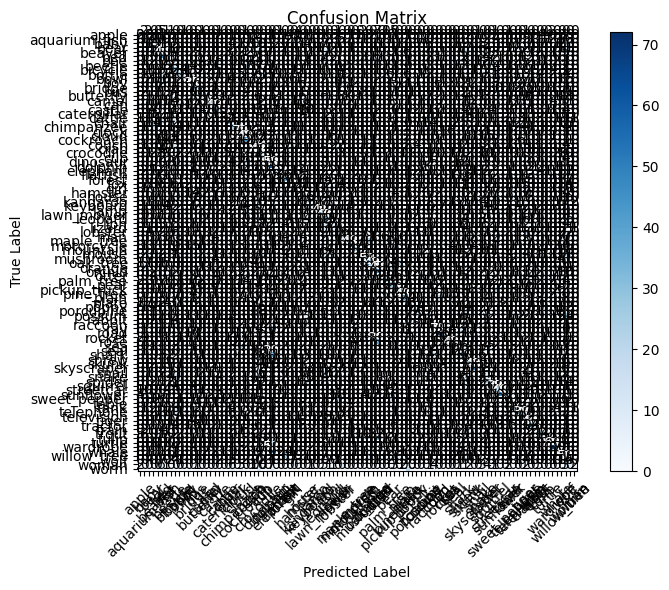

In [10]:
# Plot the confusion matrix with numeric annotations
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(cifar100_test.classes))
plt.xticks(tick_marks, cifar100_test.classes, rotation=45)
plt.yticks(tick_marks, cifar100_test.classes)

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("./images/p3_100_dropout_ResNet11_matrix.png")
plt.show()